# Building a model that is able to identify if an Image is a Cat or Dog using Transfer Learning

In [2]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from PIL import Image
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [33]:
# Data Augumentation
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = '/Users/chidubemonwuchuluba/Downloads/Cat_Dog_data'
trainset = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
testset = datasets.ImageFolder(data_dir + '/test', transform=test_transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [19]:
classes = ['cat', 'dog']

# Building the model using the DenseNet Architecture

In [9]:
model = models.densenet121(weights='IMAGENET1K_V1')
if model:
    print('model successfully imported')
else:
    print('model was not imported')
# Freeze the other layers if the model
for param in model.parameters(): 
    param.requires_grad = False
from collections import OrderedDict
# Define the architecture of the model that becomes the last layer of the densenet model
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model

model successfully imported


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 5
running_loss = 0
step = 0
print_every = 5
for i in range(epochs):
    model.train() 
    for images, labels in trainloader:
        step = step + 1
        logps = model(images)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    logps = model(images)
                    batch_loss = criterion(logps, labels)
                    test_loss = test_loss + batch_loss.item()
                    # To measure accuracy
                    ps = torch.exp(logps)
                    top_k, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {i+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
                

# Save the state_dict of the model so it can be reused without training


In [39]:
torch.save(model.state_dict(), 'densenet.pth')

# Viewing Some of the Images in the datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


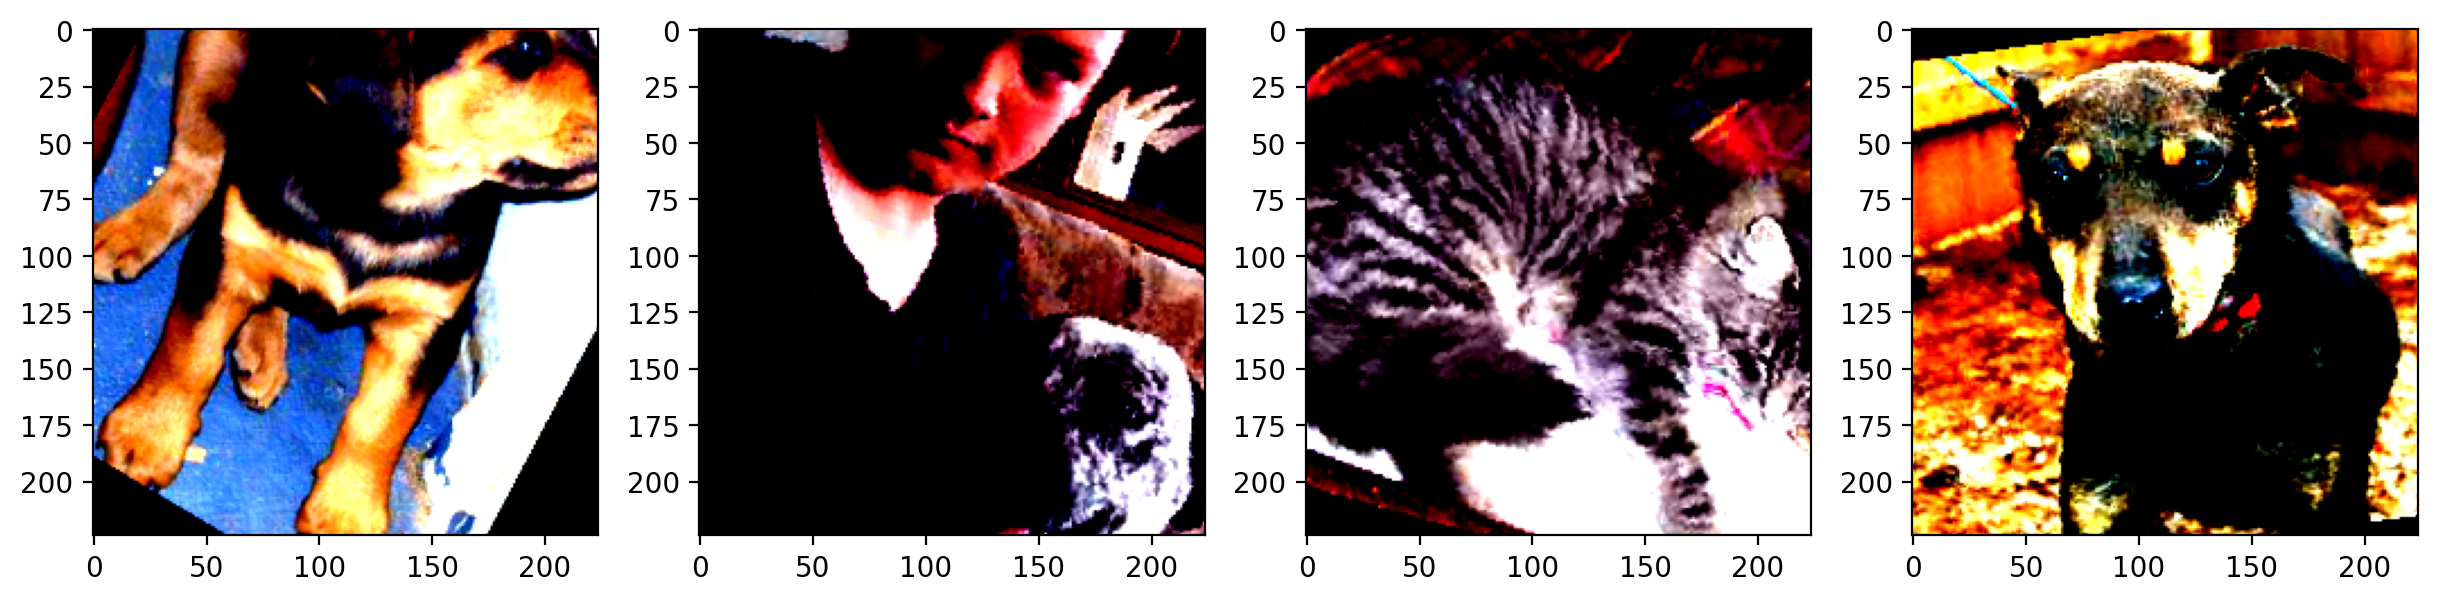

In [18]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=4)
for i in range(4):
    axes[i].imshow(images[i].permute(1, 2, 0).numpy(), cmap='YlGnBu')

In [39]:
# Densenet2.pth was a model that was trained using the same techniques but with more epochs on google colab TPU
state_dict = torch.load('densenet2.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [46]:
# We will download an image from the internet and check the models performance of the images
file_paths = ['cat.jpeg', 'cat3.jpeg', 'dog.jpeg', 'dingo.jpeg']
predictions = []
for file in file_paths:
    image = Image.open(file).convert('RGB')
    input_tensor = test_transform(image)
    input_batch = input_tensor.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        output = model(input_batch)
        predicted_class_index = torch.argmax(output).item()
        predicted_class_name = classes[predicted_class_index]
        predictions.append(predicted_class_name)
predictions

['cat', 'cat', 'dog', 'dog']

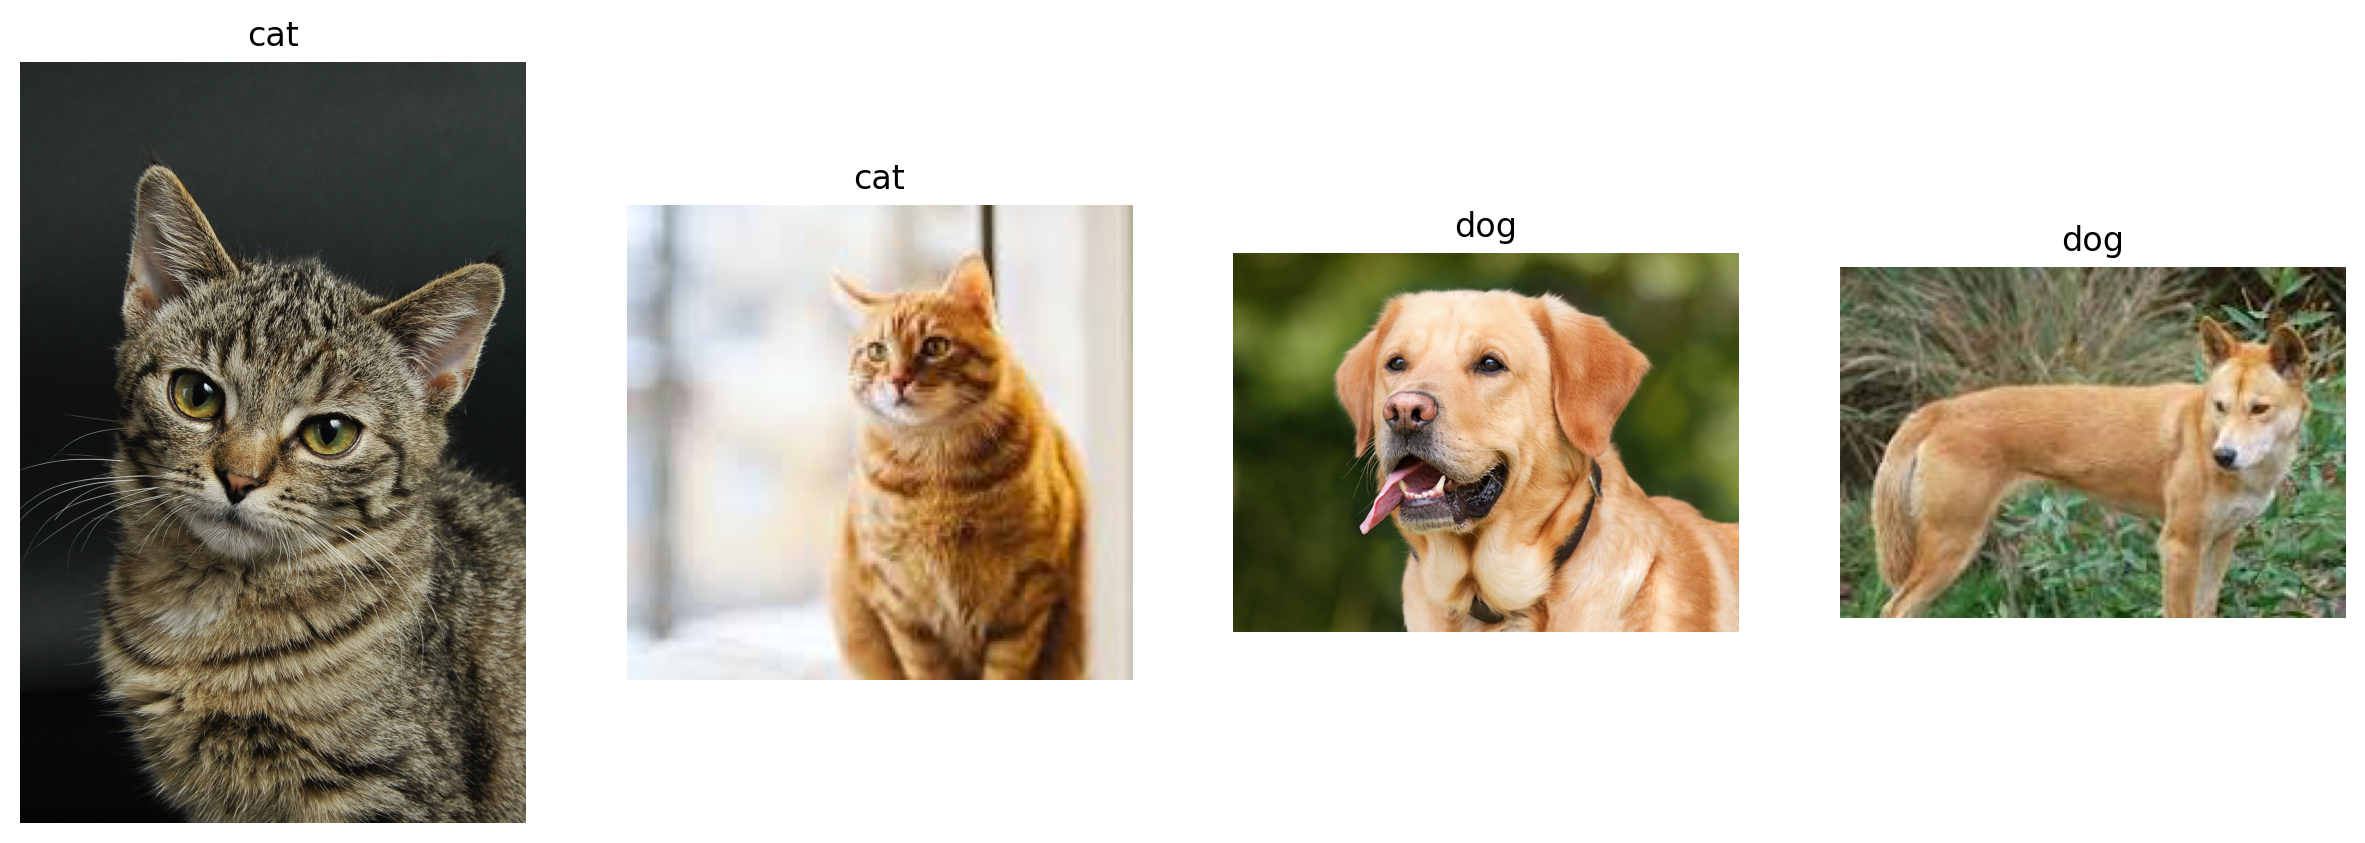

In [48]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=4)
for i in range(4):
    image = Image.open(file_paths[i]).convert('RGB')
    ax[i].imshow(image)
    ax[i].set_title(predictions[i])
    ax[i].axis('off')